# ECE 4300 - Not Hotdog

This is a tribute to the 'Not Hotdog' app from Season 4 of Silicon Valley. It is designed to be a binary classifier that will separate images of hotdogs from images of, in our case, fruit. Several different models are used, and the efficacy of each is calculated and compared.

Created by Team 15 - Emad Embarak, Mike Gargasz, Adwaya Sau

## Imports and Flickr API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io
import skimage.transform
import urllib
import requests
from io import BytesIO
import flickrapi
import os
import warnings
from random import seed
from random import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import timeit
from sklearn import metrics

In [2]:
api_key = '8fa193368446fcb9fbedaea28db13ccc'
api_secret = 'e032c5956a398644'

flickr = flickrapi.FlickrAPI(api_key, api_secret)

## Custom Function Definitions

In [3]:
def disp_image(im):
    if (len(im.shape) == 2):
        plt.imshow(im, cmap='gray')    
    else:
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    plt.xticks([])
    plt.yticks([])

This function definition has been adapted from Lab 9.

In [4]:
def grab_images(directory, keyword, ntrain, ntest):
    nrow = 64
    ncol = 64
    photos = flickr.walk(text=keyword, extras='url_c', sort='relevance', per_page=100)

    # declare directory names
    train_dir = 'train'
    test_dir = 'test'
    image_dir = directory

    # make a directories for the training and testing images
    for root_dir in [train_dir,test_dir]:
        dir_path = root_dir + '/' + image_dir

        # check if data exists
        if not os.path.isdir(root_dir):
            os.mkdir(root_dir)
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
            print("Making directory %s" % dir_path)
        else:
            print("Will store %s images in directory %s" %(root_dir,dir_path))

    # download images, first train then test
    seed(1) # make repeatable
    itrain = 0 # initialize counter
    itest = 0 # initialize counter
    for photo in photos:
        url=photo.get('url_c')
        if not (url is None):

            # Create a file from the URL
            # This may only work in Python3
            response = requests.get(url)
            file = BytesIO(response.content)

            # Read image from file
            im = skimage.io.imread(file)

            # Convert to uint8, suppress the warning about the precision loss
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                im2 = skimage.img_as_ubyte(im)

            # Set the directory randomly 
            #if (random()< ntrain/(ntrain+ntest)):
            if (random()< (ntrain-itrain)/(ntrain-itrain + ntest-itest + 1e-15)):
                if (itrain<ntrain):
                    dir_path = train_dir + '/' + image_dir
                    i = itrain
                    itrain = itrain + 1
                elif (itest<ntest):
                    dir_path = test_dir + '/' + image_dir
                    i = itest
                    itest = itest + 1
                else:
                    break
            else:
                if (itest<ntest):
                    dir_path = test_dir + '/' + image_dir
                    i = itest
                    itest = itest + 1
                elif (itrain<ntrain):
                    dir_path = train_dir + '/' + image_dir
                    i = itrain
                    itrain = itrain + 1
                else:
                    break            

            # Save the image
            local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_path,directory,i)  
            skimage.io.imsave(local_name, im2)      
            print(local_name)

This function definition has been adapted from Lab 9.

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # rearrange dimensions from (color,y,x) -> (y,x,color)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # undo the normalization
    inp = np.clip(inp, 0, 1)
    # Display image, without ticks
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)

# Acquire Data

The first step will be pulling sufficiently large numbers of hotdog and fruit images from Flickr. This will be done using the combination of keywords defined below to perform a text search of Flickr's image body.

In [6]:
hotdogs_directory = 'hotdogs'
hotdogs_keyword = 'hotdog hotdogs food'
fruit_directory = 'fruit'
fruit_keyword = 'fruit food'
computers_directory = 'computer'
computers_keyword = 'computer electronics'
aeroplane_directory = 'aeroplane'
aeroplane_keyword = 'aeroplane jet'

## Download Data from Flickr

After grabbing all the images, organize the directory as mentioned in the final report. For convenience, the data has been provided in the repository.

In [7]:
# grab_images(hotdogs_directory, hotdogs_keyword, 1000, 300)
# grab_images(fruit_directory, fruit_keyword, 1000, 300)
# grab_images(computers_directory, computers_keyword, 0, 300)
# grab_images(aeroplane_directory, aeroplane_keyword, 0, 300)

## Preprocess Data

To improve processing time, the images will be resized to 64 x 64 pixels.

In [8]:
nrow = 64
ncol= 64
batch_size = 64

In [9]:
crop = transforms.RandomResizedCrop(nrow, scale = (0.5, 1.0))
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_transform = transforms.Compose([crop, transforms.ToTensor(), normalize])

Create all dataloaders needed for this project.

In [10]:
train_ds = ImageFolder(root='train', transform = data_transform)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)

test_ds = ImageFolder(root='test/original_test', transform = data_transform)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

test_ds_aeroplane = ImageFolder(root='test/aeroplane_test', transform = data_transform)
test_dl_aeroplane = DataLoader(test_ds_aeroplane, batch_size = batch_size, shuffle = True)

test_ds_computer = ImageFolder(root='test/computer_test', transform = data_transform)
test_dl_computer = DataLoader(test_ds_computer, batch_size = batch_size, shuffle = True)

# Initial Test - Hotdogs vs. Fruits

In [11]:
lr = 1e-3
num_epoch = 5
num_images = 4

## VGG16 Implementation

Modify the model so that it works as a binary classifier.

In [12]:
from torchvision.models import vgg16
vgg_model = vgg16(pretrained = True)

for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier = nn.Sequential(
                        nn.Linear(25088, 256),
                        nn.ReLU(),
                        nn.Dropout(p = 0.5),
                        nn.Linear(256, 1),
                        nn.Sigmoid()
                    )

In [13]:
opt = optim.Adam(vgg_model.parameters(), lr = lr)
criterion = nn.BCELoss()

vgg_true_labels = []
vgg_scores = []
vgg_epoch_time = []
vgg_false_positives = []
vgg_false_negatives = []

Train the VGG model using hotdogs and fruit data.

In [14]:
for epoch in range(num_epoch):
    start_time = timeit.default_timer()

    vgg_model.train()
    batch_loss_tr = []
    
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch, y_batch = data
        y_batch = y_batch.view(-1,1)
        out = vgg_model(x_batch)
        # Compute Loss
        loss = criterion(out, y_batch.type(torch.float))
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
     
    elapsed = timeit.default_timer() - start_time
    vgg_epoch_time.append(elapsed)
    

Test the model on hotdog and fruit data, noting any fruit images that the model mistakes for a hotdog.

Images this VGG model (incorrectly) thinks are hotdogs:


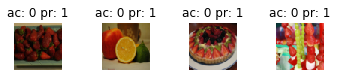

In [15]:
vgg_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this VGG model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = vgg_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            vgg_true_labels.append(item.item())
            vgg_scores.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

## ResNet Implementation

Modify the model so that it works as a binary classifier.

In [16]:
from torchvision.models import resnet152
resnet_model = resnet152(pretrained = True)

for param in resnet_model.parameters():
    param.requires_grad = False
    
resnet_model.fc = nn.Sequential(
                        nn.Linear(2048, 256),
                        nn.ReLU(),
                        nn.Dropout(p = 0.5),
                        nn.Linear(256, 1),
                        nn.Sigmoid()
                    )

In [17]:
opt = optim.Adam(resnet_model.parameters(), lr = lr)
criterion = nn.BCELoss()

resnet_true_labels = []
resnet_scores = []
resnet_epoch_time = []

Train the ResNet model using hotdogs and fruit data.

In [18]:
for epoch in range(num_epoch):
    start_time = timeit.default_timer()

    resnet_model.train()
    batch_loss_tr = []
    
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch, y_batch = data
        y_batch = y_batch.view(-1,1)
        out = resnet_model(x_batch)
        # Compute Loss
        loss = criterion(out, y_batch.type(torch.float))
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
    
    elapsed = timeit.default_timer() - start_time
    resnet_epoch_time.append(elapsed)


Test the model on hotdog and fruit data, noting any fruit images that the model mistakes for a hotdog.

Images this ResNet model (incorrectly) thinks are hotdogs:


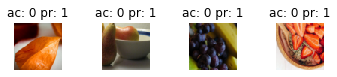

In [19]:
resnet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this ResNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = resnet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            resnet_true_labels.append(item.item())
            resnet_scores.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

## MobileNet Implementation

Modify the model so that it works as a binary classifier.

In [20]:
from torchvision.models import mobilenet_v2
mobilenet_model = mobilenet_v2(pretrained = True)

for param in mobilenet_model.parameters():
    param.requires_grad = False

mobilenet_model.classifier = nn.Sequential(
                        nn.Linear(1280, 256),
                        nn.ReLU(),
                        nn.Dropout(p = 0.2),
                        nn.Linear(256, 1),
                        nn.Sigmoid()
                    )

In [21]:
opt = optim.Adam(mobilenet_model.parameters(), lr = lr)
criterion = nn.BCELoss()

mobilenet_true_labels = []
mobilenet_scores = []
mobilenet_epoch_time = []

Train the MobileNet model using hotdogs and fruit data.

In [22]:
for epoch in range(num_epoch):
    start_time = timeit.default_timer()

    mobilenet_model.train()
    batch_loss_tr = []
    
    # iterate over training set
    for train_iter, data in enumerate(train_dl):
        x_batch, y_batch = data
        y_batch = y_batch.view(-1,1)
        out = mobilenet_model(x_batch)
        # Compute Loss
        loss = criterion(out, y_batch.type(torch.float))
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
    
    elapsed = timeit.default_timer() - start_time
    mobilenet_epoch_time.append(elapsed)


Test the model on hotdog and fruit data, noting any fruit images that the model mistakes for a hotdog.

Images this MobileNet model (incorrectly) thinks are hotdogs:


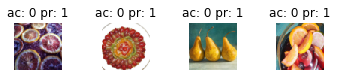

In [23]:
mobilenet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this MobileNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = mobilenet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            mobilenet_true_labels.append(item.item())
            mobilenet_scores.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

# Model Analysis

Now we will compare each of the models against each other to determine which is best for our application.

## Part 1 - Runtime Analysis

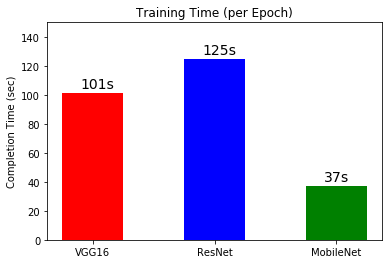

In [24]:
vgg_runtime = np.mean(vgg_epoch_time)
resnet_runtime = np.mean(resnet_epoch_time)
mobilenet_runtime = np.mean(mobilenet_epoch_time)

values = [vgg_runtime, resnet_runtime, mobilenet_runtime]
labels = ['VGG16', 'ResNet', 'MobileNet']
x = np.arange(len(labels))

fig = plt.bar(x, values, width=0.5, color=['red', 'blue', 'green'])
plt.ylabel('Completion Time (sec)')
plt.ylim((0, 150))
plt.title('Training Time (per Epoch)')
plt.xticks(x, labels)
for index,data in enumerate(values):
    plt.text(x = index - 0.1, y = data + 3, s = '{0:0.0f}s'.format(data), fontdict=dict(fontsize=14))

plt.show()

## Part 2 - ROC Analysis

Sklearn's roc_curve function is used to vary the threshold value and generate data points for the ROC curves.

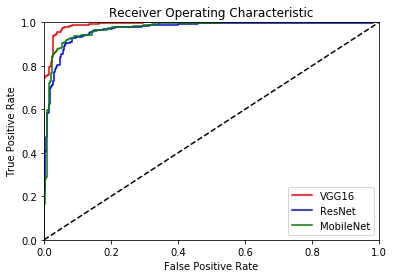

In [25]:
vgg_fpr, vgg_tpr, _ = metrics.roc_curve(vgg_true_labels, vgg_scores)
resnet_fpr, resnet_tpr, _ = metrics.roc_curve(resnet_true_labels, resnet_scores)
mobilenet_fpr, mobilenet_tpr, _ = metrics.roc_curve(mobilenet_true_labels, mobilenet_scores)

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(vgg_fpr, vgg_tpr, c = 'r', label = 'VGG16')
plt.plot(resnet_fpr, resnet_tpr, c = 'b', label = 'ResNet')
plt.plot(mobilenet_fpr, mobilenet_tpr, c = 'g', label = 'MobileNet')
plt.plot([0,1], 'k--')
plt.legend(loc = 'best')

plt.show()

## Part 3 - AUC Analysis

Sklean's auc function determines the area under the ROC curve for us.

In [26]:
vgg_auc = metrics.auc(vgg_fpr, vgg_tpr)
resnet_auc = metrics.auc(resnet_fpr, resnet_tpr)
mobilenet_auc = metrics.auc(mobilenet_fpr, mobilenet_tpr)
average_auc = np.mean([vgg_auc, resnet_auc, mobilenet_auc])

print('The AUC for the VGG curve is: {0:0.4f}'.format(vgg_auc))
print('The AUC for the ResNet curve is: {0:0.4f}'.format(resnet_auc))
print('The AUC for the MobileNet curve is: {0:0.4f}'.format(mobilenet_auc))
print('\nThe average AUC across all models is: {0:0.4f}'.format(average_auc))

The AUC for the VGG curve is: 0.9911
The AUC for the ResNet curve is: 0.9684
The AUC for the MobileNet curve is: 0.9734

The average AUC across all models is: 0.9776


## Part 4 - Hotdogs vs. Aeroplanes 

In [27]:
vgg_true_labels_aeroplane = []
vgg_scores_aeroplane = []

resnet_true_labels_aeroplane = []
resnet_scores_aeroplane = []

mobilenet_true_labels_aeroplane = []
mobilenet_scores_aeroplane = []

Testing with the VGG model on hotdog and aeroplane images.

Images this VGG model (incorrectly) thinks are hotdogs:


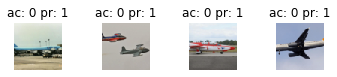

In [28]:
vgg_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this VGG model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_aeroplane:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = vgg_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            vgg_true_labels_aeroplane.append(item.item())
            vgg_scores_aeroplane.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Testing with the ResNet model on hotdog and aeroplane images.

Images this ResNet model (incorrectly) thinks are hotdogs:


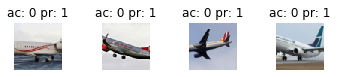

In [29]:
resnet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this ResNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_aeroplane:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = resnet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            resnet_true_labels_aeroplane.append(item.item())
            resnet_scores_aeroplane.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Testing with the MobileNet model on hotdog and aeroplane images.

Images this MobileNet model (incorrectly) thinks are hotdogs:


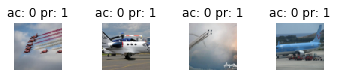

In [30]:
mobilenet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this MobileNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_aeroplane:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = mobilenet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            mobilenet_true_labels_aeroplane.append(item.item())
            mobilenet_scores_aeroplane.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Generating the ROC curve for each of the models on this dataset.

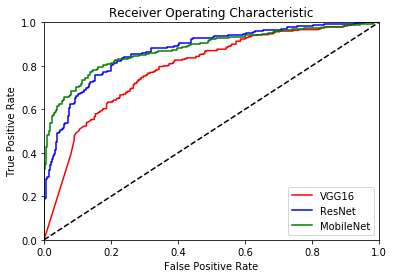

In [31]:
vgg_fpr_aeroplane, vgg_tpr_aeroplane, _ = metrics.roc_curve(vgg_true_labels_aeroplane, vgg_scores_aeroplane)
resnet_fpr_aeroplane, resnet_tpr_aeroplane, _ = metrics.roc_curve(resnet_true_labels_aeroplane, resnet_scores_aeroplane)
mobilenet_fpr_aeroplane, mobilenet_tpr_aeroplane, _ = metrics.roc_curve(mobilenet_true_labels_aeroplane, mobilenet_scores_aeroplane)

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(vgg_fpr_aeroplane, vgg_tpr_aeroplane, c = 'r', label = 'VGG16')
plt.plot(resnet_fpr_aeroplane, resnet_tpr_aeroplane, c = 'b', label = 'ResNet')
plt.plot(mobilenet_fpr_aeroplane, mobilenet_tpr_aeroplane, c = 'g', label = 'MobileNet')
plt.plot([0,1], 'k--')
plt.legend(loc = 'best')

plt.show()

Printing AUC information related to the above ROC plot.

In [32]:
vgg_auc_aeroplane = metrics.auc(vgg_fpr_aeroplane, vgg_tpr_aeroplane)
resnet_auc_aeroplane = metrics.auc(resnet_fpr_aeroplane, resnet_tpr_aeroplane)
mobilenet_auc_aeroplane = metrics.auc(mobilenet_fpr_aeroplane, mobilenet_tpr_aeroplane)
average_auc_aeroplane = np.mean([vgg_auc_aeroplane, resnet_auc_aeroplane, mobilenet_auc_aeroplane])


print('The AUC for the VGG curve is: {0:0.4f}'.format(vgg_auc_aeroplane))
print('The AUC for the ResNet curve is: {0:0.4f}'.format(resnet_auc_aeroplane))
print('The AUC for the MobileNet curve is: {0:0.4f}'.format(mobilenet_auc_aeroplane))
print('\nThe average AUC across all models is: {0:0.4f}'.format(average_auc_aeroplane))


The AUC for the VGG curve is: 0.7908
The AUC for the ResNet curve is: 0.8706
The AUC for the MobileNet curve is: 0.8779

The average AUC across all models is: 0.8464


## Part 5 - Hotdogs vs. Computers

In [33]:
vgg_true_labels_computer = []
vgg_scores_computer = []

resnet_true_labels_computer = []
resnet_scores_computer = []

mobilenet_true_labels_computer = []
mobilenet_scores_computer = []

Testing with the VGG model on hotdog and computer images.

Images this VGG model (incorrectly) thinks are hotdogs:


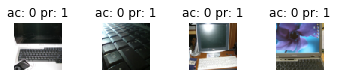

In [34]:
vgg_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this VGG model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_computer:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = vgg_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            vgg_true_labels_computer.append(item.item())
            vgg_scores_computer.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Testing with the ResNet model on hotdog and computer images.

Images this ResNet model (incorrectly) thinks are hotdogs:


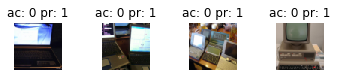

In [35]:
resnet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this ResNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_computer:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = resnet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            resnet_true_labels_computer.append(item.item())
            resnet_scores_computer.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Testing with the MobileNet model on hotdog and computer images.

Images this MobileNet model (incorrectly) thinks are hotdogs:


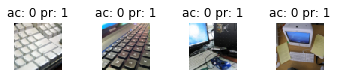

In [36]:
mobilenet_model.eval()
images_so_far = 0
fig = plt.figure()
print('Images this MobileNet model (incorrectly) thinks are hotdogs:')
with torch.no_grad():
    for data in test_dl_computer:
        images, labels = data
        labels = labels.view(-1,1)
        outputs = mobilenet_model(images)
        predicted = outputs.clamp(0,1).round().type(torch.long)
        for i, item in enumerate(labels):
            mobilenet_true_labels_computer.append(item.item())
            mobilenet_scores_computer.append(outputs[i].item())
            if (predicted[i].item() != labels[i].item() and labels[i].item() == 0):
                images_so_far += 1
                if (images_so_far <= num_images):
                    ax = plt.subplot(num_images, num_images, images_so_far)
                    ax.axis('off')
                    ax.set_title('ac: {:d} pr: {:d}'.format(labels[i].item(), predicted[i].item()))
                    imshow(images.data[i])

Generating the ROC curve for each of the models on this dataset.

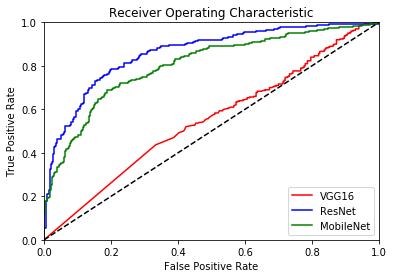

In [37]:
vgg_fpr_computer, vgg_tpr_computer, _ = metrics.roc_curve(vgg_true_labels_computer, vgg_scores_computer)
resnet_fpr_computer, resnet_tpr_computer, _ = metrics.roc_curve(resnet_true_labels_computer, resnet_scores_computer)
mobilenet_fpr_computer, mobilenet_tpr_computer, _ = metrics.roc_curve(mobilenet_true_labels_computer, mobilenet_scores_computer)

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(vgg_fpr_computer, vgg_tpr_computer, c = 'r', label = 'VGG16')
plt.plot(resnet_fpr_computer, resnet_tpr_computer, c = 'b', label = 'ResNet')
plt.plot(mobilenet_fpr_computer, mobilenet_tpr_computer, c = 'g', label = 'MobileNet')
plt.plot([0,1], 'k--')
plt.legend(loc = 'best')

plt.show()

Printing AUC information related to the above ROC plot.

In [38]:
vgg_auc_computer = metrics.auc(vgg_fpr_computer, vgg_tpr_computer)
resnet_auc_computer = metrics.auc(resnet_fpr_computer, resnet_tpr_computer)
mobilenet_auc_computer = metrics.auc(mobilenet_fpr_computer, mobilenet_tpr_computer)
average_auc_computer = np.mean([vgg_auc_computer, resnet_auc_computer, mobilenet_auc_computer])

print('The AUC for the VGG curve is: {0:0.4f}'.format(vgg_auc_computer))
print('The AUC for the ResNet curve is: {0:0.4f}'.format(resnet_auc_computer))
print('The AUC for the MobileNet curve is: {0:0.4f}'.format(mobilenet_auc_computer))
print('\nThe average AUC across all models is: {0:0.4f}'.format(average_auc_computer))

The AUC for the VGG curve is: 0.5488
The AUC for the ResNet curve is: 0.8593
The AUC for the MobileNet curve is: 0.8028

The average AUC across all models is: 0.7370


## Part 6 - AUC Comparison

This plot will compare the average AUC across all three test cases.

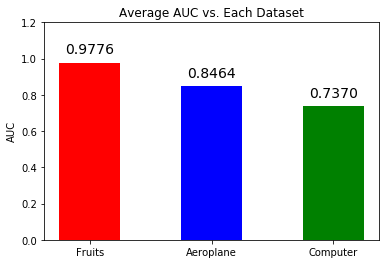

In [39]:
values = [average_auc, average_auc_aeroplane, average_auc_computer]
labels = ['Fruits', 'Aeroplane', 'Computer']
x = np.arange(len(labels))

fig = plt.bar(x, values, width=0.5, color=['red', 'blue', 'green'])
plt.ylabel('AUC')
plt.ylim((0, 1.2))
plt.title('Average AUC vs. Each Dataset')
plt.xticks(x, labels)
for index,data in enumerate(values):
    plt.text(x = index - 0.2 , y = data + 0.05, s = '{0:0.4f}'.format(data), fontdict=dict(fontsize=14))

plt.show()

# That's everything! Thanks for a great semester!